# Algoritmo para resolver problema de reconhecimento de caracteres

In [1]:
import pandas as pd
import numpy as np
import math
import os
import random
from matplotlib import pyplot as plt
import seaborn as sns

# Configurações do Pandas
pd.set_option("display.float_format", lambda x: "%.5f" % x)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 200)

# Ajustar tamanho do notebook ao tamanho da janela
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:95% !important; } </style>"))

# Imprimir todos valores da célula, não somente o último
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"


Methods to read input .csv data files

In [2]:
#Data inputs
#Função para receber a entrada do conjunto de dados para treinamento do Percepton
def data_input(usecase):
    '''Recebe dados para usar na rede neural
    par: str usecase 
        training --> training dataset
        input_set --> input data to be used after training'''
    
    directory = os.path.abspath(os.getcwd())
    
    if usecase == "training":
        print("\nChoose training dataset:\n")
    elif (usecase == "validation"):
        print("\nChoose validation dataset:\n")
    elif (usecase == "test"):
        print("\nChoose test dataset:\n")
    else:
        print("\nChoose a dataset:\n")
    print("\t1 - Limpo")
    print("\t2 - Ruido")
    print("\t3 - Ruido 20")
    escolha = 0
    while escolha not in [1,2,3]:
        try:
            escolha = int(input("\nPick an option: "))
            if escolha not in [1,2,3]:
                print("Invalid entry. Choose 1, 2 or 3...")
        except ValueError:
            print("Invalid entry. Choose 1, 2 or 3...")
            
    if escolha ==1:
        df = pd.read_csv(directory + "\Conjunto de dados\caracteres-limpo.csv", header = None)
    elif escolha ==2:
        df = pd.read_csv(directory + "\Conjunto de dados\caracteres-ruido.csv", header = None)
    elif escolha == 3:
         df = pd.read_csv(directory + "\Conjunto de dados\caracteres_ruido20.csv", header = None)
    
    return df;

Function to generate random values for weights matrixes initialization

In [3]:
def generate_random_weights(nlin, ncol):
    '''Function to generate weights matrix with random values between -0.5 and 0.5 at nlin x ncol shape'''
    rand_int = np.random.randint(-50,50,(nlin, ncol))
    return rand_int/100

Activation function and its derivative

In [4]:
def activation_function(arg):
    #return 2/(1+math.exp(-arg)) - 1 #Bipolar 
    return 1/(1+math.exp(-arg))  #Binary

def derivative_activation_function(arg):
    '''Apply derivative of activation funtion over a single value'''
    #return 0.5*(1 + activation_function(arg))*(1 - activation_function(arg)) #Bipolar
    return activation_function(arg)*(1 - activation_function(arg)) #Binary
    
def activation_function_array(ndarray):
    '''Apply derivative of activation funtion over a numpy array'''
    vfunc = np.vectorize(activation_function)
    return vfunc(ndarray)

def derivative_activation_function_array(ndarray):
    '''Apply derivative of activation funtion over a numpy array'''
    vfunc = np.vectorize(derivative_activation_function)
    return vfunc(ndarray)

Training algorithm - Reference Fausset p. 294

In [5]:
##Algoritmo de treinamento

def training_algorithm(dataset, v_ini, w_ini, labels, p, tol, a, itmax, early_stop):
    
    '''inputs: dataset (pandas dataframe), labels (int), p (int), tol (float), a (float), itmax (int), early_stop(bool)
       outputs: v (ndarray), w (ndarray), n (int), v_ini (ndarray), w_ini (ndarray), it (int), sqError_vec (array);'''
    
    #Based on Fausset p.294
    
    n = len(dataset.columns) - labels #Numero de atributos descritivos. Considerar apenas colunas com xi (as últimas colunas são rótulo)
    
    s = dataset.iloc[:, 0:n].copy().values #Atributos
    t = dataset.iloc[:, n:n+labels].copy().values #Rótulos
    
    s_n = len(dataset.index) #Number of training patterns (= number of rows from dataset)
    
    #Initialize weights and bias (random values between -0.5 and 0.5)
    v = v_ini.copy() 
    w = w_ini.copy() 
    
    #While stopping condition 

    sqError_vec = [] #Array to store sqError on every iteration
    it = 0
    while (it<itmax):
        
        print("Running training algorithm...", end='\r')
                       
        #For each training set s:t,
        for tset in range(s_n): #O laço for computa uma época
            
            sqError = 0
            
            #FEEDFORWARD
                                
            #Each input unit (Xi, i=[1, n])receives input signal xi
            xi = s[tset].copy()
            xi = np.insert(xi,0,1) #insere o valor 1 no início do vetor x (neurônio do bias)
                        
            #Each hidden unit (Zj, j=[1, p]) sum its weighted input signals
            z_inj = np.dot(v, xi)
            
            #Applies its activation function to compute its output signal
            zj = activation_function_array(z_inj)
            zj = np.insert(zj,0,1) #insere o valor 1 no início do vetor
            
            #Each output unit (Yk, k=[1,m]) sums its weighted input signals
            y_ink = np.dot(w, zj)
            
            #Applies its activation function to compute its output signal
            yk = activation_function_array(y_ink)
            
            error = yk - t[tset] #Calculate error for stopping condition

            #BACKPROPAGATION OF ERROR
            
            #Each output unit Yk receives a target pattern corresponding to the input training pattern
            #Compute its error (dk) information term
            dk = (t[tset] - yk)*derivative_activation_function_array(y_ink)
            
            #Calculate its weight and bias correction term
            delta_wjk = a*np.dot(dk[:,None],zj[None,:]) #Trick to multiply two 1D matrix in numpy
            
            #Each hidden unit Zj sums its delta inputs from the units above
            d_inj = np.dot(dk, w[:,1:])
            
            #multiplies by the derivative of its activation function to calculate its error information term,
            dj = d_inj*derivative_activation_function_array(z_inj)  
            
            #Calculate its weight correction term
            delta_vij = a*np.dot(dj[:,None],xi[None,:])
                        
            #Update weights and bias if an error ocurred for this pattern
            
            #Each output unit Yk updates its bias and weights
            w += delta_wjk
            
            #Each output unit Zj updates its bias and weights
            v += delta_vij
            
            #Test stopping condition
            sqError += np.sum(error**2)
        
        it+=1
        if it == itmax:
            print("Max number of iterations reached: itmax = ",itmax)
        sqError = sqError/s_n
        sqError_vec.append(sqError)
        if sqError <= tol and early_stop == False: #If early_stop is off, the algorithm stop when tolerance is reached
            break
        
    print("                                              ", end='\r')
    
    return v, w, n, it, sqError_vec;

Application procedure

In [6]:
def application_procedure(v, w, dataset, labels):
    
    '''inputs: v(ndarray), w(ndarray), inputs (pandas dataframe)
    output: categorias (array)'''
    
    #Set activation of inputs
    s_n = len(dataset) #Number of inputs (= number of rows from dataset)
    
    n = len(dataset.columns) - labels #Numero de atributos descritivos. Considerar apenas colunas com xi (a última coluna é rótulo)
    
    s = dataset.iloc[:, 0:n].copy().values #Atributos
    t = dataset.iloc[:, n:n+labels].copy().values #Rótulos
    
    categorias =[] #Store results for each input
    
    sqError = 0
    
    for aset in range (s_n): #For each input(aset = application set)
        
        print("Proceding with application...", end='\r')
        
        #Compute response of output unit
        xi = np.array(s[aset,:].copy())
        xi = np.insert(xi,0,1)
        
        z_inj = np.dot(v, xi)
        zj = activation_function_array(z_inj)
        zj = np.insert(zj,0,1)
        
        y_ink = np.dot(w, zj)
        
        yk = activation_function_array(y_ink)
        categorias.append(yk)
        
        error = yk - t[aset]
        sqError += np.sum(error**2)
            
    print("                               ", end='\r')
    
    return list(categorias), sqError/s_n;

Methods for renderization of characters as comprehensible images

In [7]:
#Funções para visualizar os Caracteres como imagem

def show_char_img(character):
    '''input: (ndarray) 1D - array with 63 elements 
     return: renderzation of a 9x7 image based on the array'''
    character = character.reshape(9,7)
    plt.imshow(character, interpolation='nearest')
    plt.show()

def compare_char_img(input_set, expected_result):
    
    '''input_set: (ndarray) an array with the results of the input data elements
       expected_result: (ndarray) an array with the expected results from the neural net to be compared with input_set
     
     return: all elements plotted side by side'''
    
    print("===============================\nCHARACTER COMPARISON\n===============================")
    
    f, axarr = plt.subplots(len(input_set),2, figsize=(7,5*len(input_set)))
    
    for i in range(len(input_set)):
        axarr[i,0].imshow(input_set[i,:].reshape(9,7), interpolation='nearest')
        axarr[i,0].set_title("Input data [" + str(i) + "]")
        axarr[i,1].imshow(expected_result[i,:].reshape(9,7), interpolation='nearest')
        axarr[i,1].set_title("Expected data [" + str(i) + "]")
        plt.title("Expected data [" + str(i) + "]")

    plt.show() 

Dictinary with characters representation

In [8]:
alphabet = {
  "A": [1,0,0,0,0,0,0],
  "B": [0,1,0,0,0,0,0],
  "C": [0,0,1,0,0,0,0],
  "D": [0,0,0,1,0,0,0],
  "E": [0,0,0,0,1,0,0],
  "J": [0,0,0,0,0,1,0],
  "K": [0,0,0,0,0,0,1]
    
}

Methods for neural net results visualization

In [9]:
#Função para validação do resultado da rede neural

def validation(net_results, expected_results):
    '''ndarray, ndarray --> boolean
    Compares the result from the neural net with a expected know result.'''
    return np.equal(net_results, expected_results)

def validation_show(input_set, net_results, expected_results, labels):
    '''inputs: (ndarray), (ndarray), (pandas dataframe), (int)
        input_set: input data on neural net
        net_result: results of the neural net classification
        expectec_results: used for comparisson
        labels: number of labels'''
    
    expected_labels = expected_results.iloc[:,-labels:].to_numpy()
    expected_char = expected_results.iloc[:,0:-labels].to_numpy()
    
    print("===============================\nCORRECTNESS\n===============================")
    print(pd.DataFrame(validation(net_results, expected_labels)))
    compare_char_img(input_set.to_numpy(), expected_char)

#Função que imprime um relatório da execução da rede

def show_execution_report(n, p, labels, a, tol, itmax, v_ini, w_ini, v, w, it):   
    print("\n===============================\nEXECUTION REPORT\n===============================")
    print("Neural net architeture")
    print("\tNumber of input units: ", n)
    print("\tNumber of hidden units: ", p)
    print("\tNumber of output units: ", labels)
    print("\nInicialization parameters")
    print("\t Learning rate: ", a)
    print("\t Tolerance: ", tol)
    print("\t Max. iterations number: ", itmax)
    print("\tWeights of input units:\n", v_ini)
    print("\tWeights of hidden units:\n", w_ini)
    print("\nFinal weights")
    print("\tWeights of input units:\n", v)
    print("\tWeights of hidden units:\n", w)
    print("\nNumber of epochs until stopping condition: ", it)
    print("")

#Função que gera um gráfico com o erro por época

def plt_sqError(it, sqError_vec):
    print("===============================\nERROR ANALYSIS\n===============================")
    plt.plot(np.arange(it), np.array(sqError_vec))
    plt.title("Neural net error")
    plt.xlabel("Number of epochs")
    plt.ylabel("Error")
    plt.show()

In [10]:
def output_neural_net(net_result, expected, my_dict, labels): 
    
    '''
        input: net_result (ndarray), expected (pandas dataframe), my_dict (python dictionary), labels(int)
        output: out(ndarray)
        
        Receives the results of a neural net, the expected results, the alphabet dictionary and the numer of labels.
        Translates an array in a character
    '''

    key_list = list(my_dict.keys())
    val_list = list(my_dict.values())
    
    print("===============================\nOUTPUT\n===============================")

    out = pd.DataFrame(net_result, dtype = int)

    char_column=[]
    expected_char_column=[]
    
    for i in range (len(out.index)):
        char = list(out.iloc[i,:])
        char_expected = list(expected.iloc[i,-labels:])

        
        try:
            position = val_list.index(char)
            char_column.append(key_list[position])
        except:
            char_column.append(None)
        
        position_expected = val_list.index(char_expected)
        expected_char_column.append(key_list[position_expected])
        

    out[labels] = char_column
    out[labels + 1] = expected_char_column
    print(out)
    return out

def build_cofusion_matrix(real, predicted, my_dict):
    
    print("===============================\nCONFUSION MATRIX\n===============================")
        
    alphabet = key_list = list(my_dict.keys())
    n = len(alphabet)
    
    confusion_matrix = pd.DataFrame(
        np.zeros((n, n)),
        columns=alphabet,
        index=alphabet
    )
    
    for r, p in zip(real, predicted):
        try:
            confusion_matrix.loc[r, p] += 1
        except:
            pass
        
    return confusion_matrix  


# Main program

In [11]:
def data_set_visualization():
    
    data = data_input("visualization")
    #with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
        #print(data)
    data = data.iloc[:,0:- labels]
    for i in range(len(data.index)):
        show_char_img(data.iloc[i,:].to_numpy())
    
def training_and_validation(labels, tol, a, p, itmax):
        
    #Define initialization parameters
        
    trainig_set = data_input("training")
    validation_set = data_input("validation")
    
    #labels = 7
    n = len(trainig_set.columns) - labels
    m = labels
    #tol = 1e-4
    #itmax = 10000
    #a=0.5 #Learning rate
    
    #Initial weights
    v_ini = generate_random_weights(p, n+1) #Store initialization parameters
    w_ini = generate_random_weights(m, p+1) #Store initialization parameters
        
    #Training and validation of algorithm
    early_stop = True
        
    #Esse looping gera os dados para análise de overfitting
    error_training = []
    error_validation = []
    epoch = []
    for i in range(50, 900, 150):
        itmax = i
        v, w, n, it, sqError_vec_training = training_algorithm(trainig_set, v_ini, w_ini, labels, p, tol, a, itmax, early_stop)
        net_results, sqError_val = application_procedure(v, w, validation_set, labels)
        error_training.append(sqError_vec_training[-1])
        error_validation.append(sqError_val)
        epoch.append(i)
     
    #Graphic to display results
    
    fig, ax1 = plt.subplots()

    ax2 = ax1.twinx()
    line1 = ax1.plot(epoch, error_training, 'r-', label='Training set')
    line2 = ax2.plot(epoch, error_validation, 'b-', label='Validation set')
    
    lines = line1 + line2
    labs = [l.get_label() for l in lines]
    ax1.legend(lines, labs, loc=0)
    

    ax1.set_xlabel("Number of epochs")
    ax1.set_ylabel("Error training set")
    ax2.set_ylabel("Error validation set")
    plt.show()    

def neural_net_application(labels, tol, a, p, itmax):
    
    trainig_set = data_input("training")
    input_set = data_input("test")
    
    n = len(trainig_set.columns) - labels
    m = labels
    
    #Define a expected results matrix for further comparisson
    directory = os.path.abspath(os.getcwd())
    expected_results = pd.read_csv(directory + "\Conjunto de dados\caracteres-limpo.csv", header = None)
    
    #Define initialization parameters for training
    early_stop = False
    v_ini = generate_random_weights(p, n+1) #Store initialization parameters
    w_ini = generate_random_weights(m, p+1) #Store initialization parameters
    
    #Apply training algorithm
    v, w, n, it, sqError_vec = training_algorithm(trainig_set, v_ini, w_ini, labels, p, tol, a, itmax, early_stop)
    
    #Proceed with classification of test data
    net_results = application_procedure(v, w, input_set, labels)[0]
    net_results = np.round(net_results)
    
    #Show execution report
    show_execution_report(n, p, labels, a, tol, itmax, v_ini, w_ini, v, w, it)
    
    #Show the test data classification
    out = output_neural_net(net_results, expected_results, alphabet, labels)
    
    #Plot error of training algorithm
    plt_sqError(it, sqError_vec)
    
    #Create confusion matrix
    confusion_matrix = build_cofusion_matrix(list(out[labels]), list(out[labels+1]), alphabet)
    plt.title("Confusion matrix")
    sns.heatmap(confusion_matrix, annot=True, cmap='Blues')
    plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True)
    plt.yticks(rotation = 0)
    plt.show()
        
    #Compares classification with expected results
    validation_show(input_set.iloc[:,:-labels], net_results, expected_results, labels)


Global variables

In [12]:
labels = 7
tol = 1e-4 #Error tolerance
a = 0.5 #Learning rate
itmax = 10000 #Max number of iterations 
p = 9 #Number of hidden units

Data visualization


Choose a dataset:

	1 - Limpo
	2 - Ruido
	3 - Ruido 20

Pick an option: 1


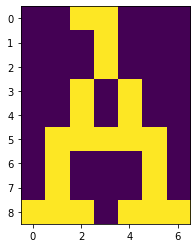

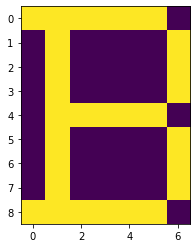

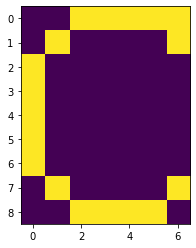

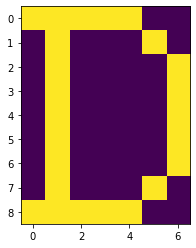

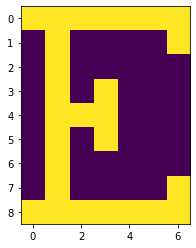

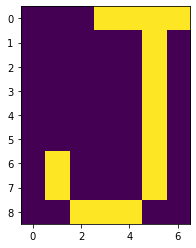

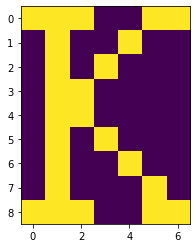

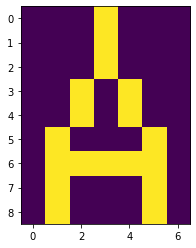

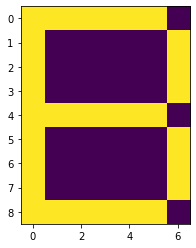

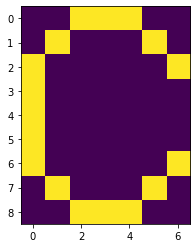

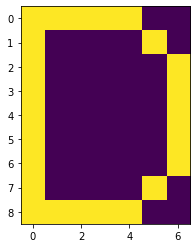

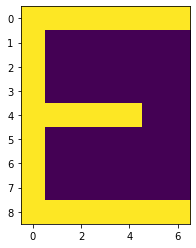

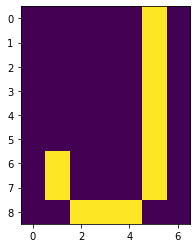

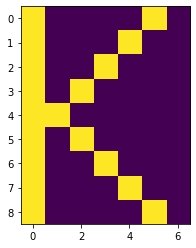

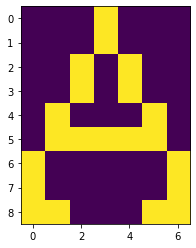

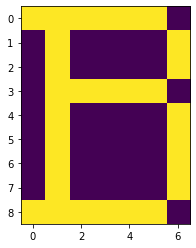

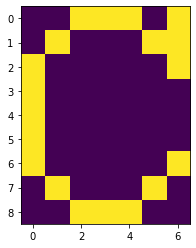

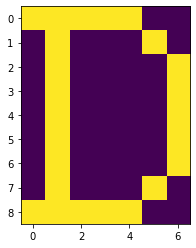

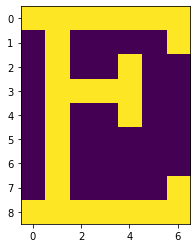

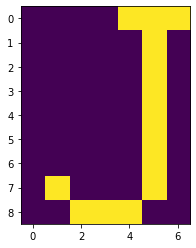

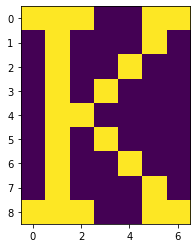

In [13]:
data_set_visualization()

Training and validation


Choose training dataset:

	1 - Limpo
	2 - Ruido
	3 - Ruido 20

Pick an option: 2

Choose validation dataset:

	1 - Limpo
	2 - Ruido
	3 - Ruido 20

Pick an option: 1
Max number of iterations reached: itmax =  50
Max number of iterations reached: itmax =  200
Max number of iterations reached: itmax =  350
Max number of iterations reached: itmax =  500
Max number of iterations reached: itmax =  650
Max number of iterations reached: itmax =  800


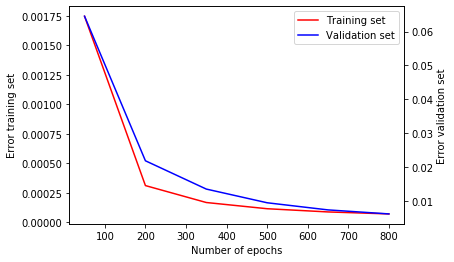

In [14]:
training_and_validation(labels, tol, a, p, itmax)

Neural net application


Choose training dataset:

	1 - Limpo
	2 - Ruido
	3 - Ruido 20

Pick an option: 1

Choose test dataset:

	1 - Limpo
	2 - Ruido
	3 - Ruido 20

Pick an option: 2
                                              
EXECUTION REPORT
Neural net architeture
	Number of input units:  63
	Number of hidden units:  9
	Number of output units:  7

Inicialization parameters
	 Learning rate:  0.5
	 Tolerance:  0.0001
	 Max. iterations number:  10000
	Weights of input units:
 [[ 0.25  0.36  0.35 -0.3   0.44 -0.46 -0.1  -0.26  0.41  0.34  0.3   0.34
  -0.07 -0.13  0.26  0.31 -0.17 -0.45  0.47 -0.05 -0.07 -0.44  0.06  0.4
   0.48 -0.32  0.04 -0.42 -0.03 -0.21  0.49 -0.22 -0.29 -0.05  0.37  0.21
   0.26 -0.19  0.32 -0.48 -0.03 -0.37 -0.32  0.18  0.35 -0.49 -0.1   0.36
   0.02  0.15  0.42 -0.2   0.44 -0.43  0.25  0.23  0.32  0.3   0.2   0.33
   0.31 -0.31 -0.38  0.38]
 [-0.1  -0.42 -0.3   0.25 -0.43  0.23 -0.47 -0.25 -0.14  0.13 -0.33  0.06
   0.12  0.03 -0.3  -0.03  0.03  0.42  0.07  0.37 -0.38 -0.04 -0.47 -0

    0  1  2  3  4  5  6  7  8
0   1  0  0  0  0  0  0  A  A
1   0  1  0  0  0  0  0  B  B
2   0  0  1  0  0  0  0  C  C
3   0  0  0  1  0  0  0  D  D
4   0  0  0  0  1  0  0  E  E
5   0  0  0  0  0  1  0  J  J
6   0  0  0  0  0  0  1  K  K
7   1  0  0  0  0  0  0  A  A
8   0  1  0  0  0  0  0  B  B
9   0  0  1  0  0  0  0  C  C
10  0  0  0  1  0  0  0  D  D
11  0  0  0  0  1  0  0  E  E
12  0  0  0  0  0  1  0  J  J
13  0  0  0  0  0  0  1  K  K
14  1  0  0  0  0  0  0  A  A
15  0  1  0  0  0  0  0  B  B
16  0  0  1  0  0  0  0  C  C
17  0  0  0  1  0  0  0  D  D
18  0  0  0  0  1  0  0  E  E
19  0  0  0  0  0  1  0  J  J
20  0  0  0  0  0  0  1  K  K
ERROR ANALYSIS


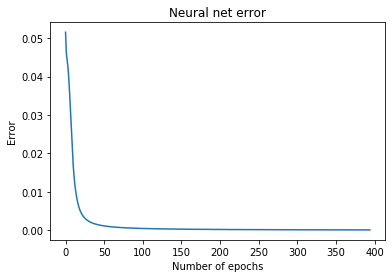

CONFUSION MATRIX


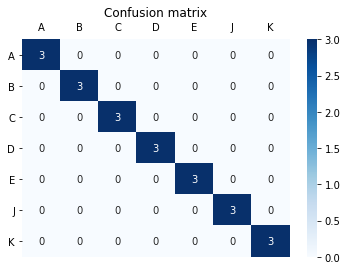

CORRECTNESS
       0     1     2     3     4     5     6
0   True  True  True  True  True  True  True
1   True  True  True  True  True  True  True
2   True  True  True  True  True  True  True
3   True  True  True  True  True  True  True
4   True  True  True  True  True  True  True
5   True  True  True  True  True  True  True
6   True  True  True  True  True  True  True
7   True  True  True  True  True  True  True
8   True  True  True  True  True  True  True
9   True  True  True  True  True  True  True
10  True  True  True  True  True  True  True
11  True  True  True  True  True  True  True
12  True  True  True  True  True  True  True
13  True  True  True  True  True  True  True
14  True  True  True  True  True  True  True
15  True  True  True  True  True  True  True
16  True  True  True  True  True  True  True
17  True  True  True  True  True  True  True
18  True  True  True  True  True  True  True
19  True  True  True  True  True  True  True
20  True  True  True  True  True  True  Tru

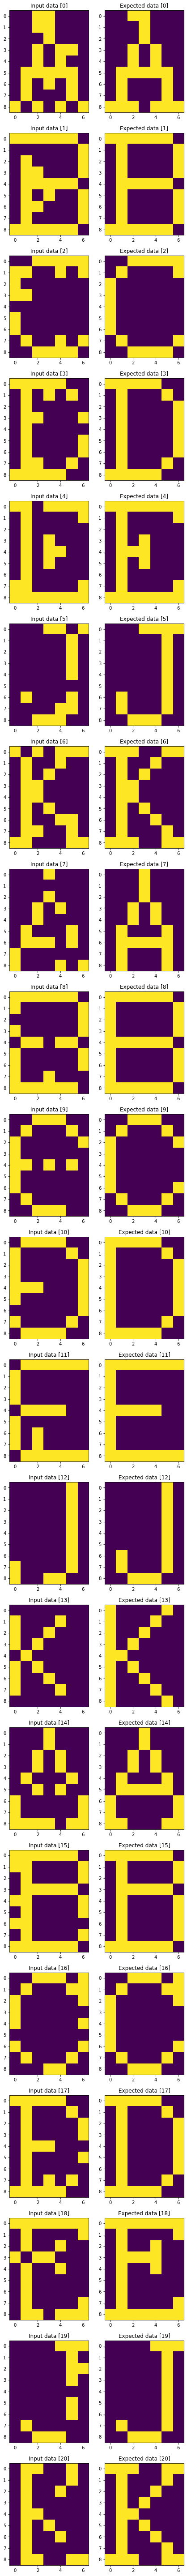

In [15]:
neural_net_application(labels, tol, a, p, itmax)